# Genetic algorithm: Sudoku
**Ricardo Antonio Gutiérrez Esparza** \
**Juan Marquina Cancino**

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import csv
rng = default_rng(6502729091)

## Genotype definition
Array of 81 elements. Every 9 elements represent an inner square, starting from the top left to the bottom right.

In [2]:
def SquareToLinear(arr):
    '''Auxiliar function. Takes a 9x9 array representing a sudoku,
       returns an array with the same sudoku encoded in the 
       described way.
    '''
    result = np.zeros(81, dtype=int)
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            result[idx * 9 : (idx + 1) * 9] = np.reshape(arr[i * 3:(i + 1) * 3, j * 3 : (j + 1) * 3], (9))
    return result

In [3]:
def LinearToSquare(arr):
    '''Auxiliar function. Takes a sudoku encoded in the described
       way and returns a 9x9 array representing the same sudoku.
    '''
    result = np.zeros((9,9), dtype=int)
    for i in range(3):
        for j in range(3):
            idx = i * 3 + j
            result[i * 3:(i + 1) * 3, j * 3:(j + 1) * 3] = np.reshape(arr[idx * 9 : (idx + 1) * 9], (3,3))
    return result

In [4]:
# Genotype example
genotype = np.array([i for i in range(81)])
print(f'The genotype {genotype} represents the following sudoku: ')
print(LinearToSquare(genotype))

The genotype [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80] represents the following sudoku: 
[[ 0  1  2  9 10 11 18 19 20]
 [ 3  4  5 12 13 14 21 22 23]
 [ 6  7  8 15 16 17 24 25 26]
 [27 28 29 36 37 38 45 46 47]
 [30 31 32 39 40 41 48 49 50]
 [33 34 35 42 43 44 51 52 53]
 [54 55 56 63 64 65 72 73 74]
 [57 58 59 66 67 68 75 76 77]
 [60 61 62 69 70 71 78 79 80]]


In [5]:
def ObjectiveFunction(genotype):
    '''Counts the amount of repeated elements per row and column.
       It is not necessary to check inner squares because the
       random generation function ensures that there are not 
       repeated elements in inner squares.
    '''
    ans = 0
    # Rows
    raux = np.reshape(genotype, (9,9))
    for i in range(3):
        for j in range(3):
            ans += 9 - len(np.unique(raux[i * 3 : (i + 1) * 3, j * 3 : (j + 1) * 3]))
    
    # Columns
    caux = np.reshape(genotype, (9,3,3))
    for i in range(3):
        for j in range(3):
            ans += 9 - len(np.unique(caux[i::3][:,:,j]))
    
    return ans

In [6]:
def FillObvious(genotype):
    '''Goes through the given solution and fills the values
       where there is no other choice.
    '''
    board = LinearToSquare(genotype)
    possible = np.array([[{1,2,3,4,5,6,7,8,9} for i in range(9)] for i in range(9)])
    
    def DiscardRow(r, x):
        for s in possible[r]:
            s.discard(x)
    def DiscardColumn(c, x):
        for s in possible[:,c]:
            s.discard(x)
    def DiscardInnerSquare(n, m, x):
        for r in possible[n * 3:(n + 1) * 3, m * 3:(m + 1) * 3]:
            for s in r:
                s.discard(x)
    
    for i in range(9):
        for j in range(9):
            if board[i,j] != 0:
                DiscardRow(i, board[i,j])
                DiscardColumn(j, board[i,j])
                DiscardInnerSquare(i // 3, j // 3, board[i,j])
    
    changed = 0
    for i in range(9):
        for j in range(9):
            if len(possible[i,j]) == 1 and board[i,j] == 0:
                board[i,j] = list(possible[i,j])[0]
                changed += 1
    
    print(f'Filled {changed} values')
    return SquareToLinear(board)

In [7]:
def SolutionPermutation(initialState):
    '''Fills the sudoku with random values, respecting the 
       given constraints (fixed values).
    '''
    solution = np.zeros(81, dtype=int)
    for i in range(9):
        perm = rng.permutation(9) + 1
        for j, x in enumerate(initialState[i * 9 : (i + 1) * 9]):
            if x != 0:
                perm[np.where(perm == x)[0]] = perm[j]
                perm[j] = x
        solution[i * 9 : (i + 1) * 9] = perm.copy()
        
    return solution

In [8]:
def ReadFromCSV(path):
    ans = np.zeros((9,9), dtype=int)
    with open(path) as f:
        csvf = csv.reader(f, delimiter=',')
        for i, r in enumerate(csvf):
            ans[i] = r
    
    return SquareToLinear(ans)

## Genetic Algorithm

In [9]:
def ParentSelectionTournament(fitness, k=2):
    '''
        Input:  fitness -> Array of pop_size elements
                k -> size of tournament
        Output: Index of selected parent
    '''
    selection = rng.permutation(len(fitness))
    not_selection = selection[k:]
    raffle = fitness.copy()
    raffle[not_selection] = np.max(raffle) + 1
    return np.argmin(raffle)

In [10]:
def CrossoverSimplePermutation(parent1, parent2):
    '''Crossover function. Takes a random crossover point
       to combine the inner squares of the parents
    '''
    cut = rng.integers(low=1, high=8)
    return np.append(parent1[:cut * 9], parent2[cut * 9:])

In [11]:
def MutationSwap(genotype, initialState):
    '''Randomly selects an inner square and swaps two 
       non-fixed values
    '''
    mutated = genotype.copy()
    helper = np.reshape(initialState, (9,9))
    mutated = np.reshape(mutated, (9,9))
    
    r_idx, cnt_not_fixed = None, None
    while True:
        r_idx = rng.integers(low=0, high=9)
        cnt_not_fixed = np.count_nonzero(helper[r_idx] == 0)
        if cnt_not_fixed >= 2:
            break
    
    g = rng.integers(low=0, high=cnt_not_fixed, size=2)
    
    c_idx1 = 0
    for i,x in enumerate(helper[r_idx]): 
        if g[0] == 0 and x == 0:
            c_idx1 = i
            break
        if x == 0:
            g[0] -= 1
    
    c_idx2 = 0
    for i,x in enumerate(helper[r_idx]): 
        if g[1] == 0 and x == 0:
            c_idx2 = i
            break
        if x == 0:
            g[1] -= 1
    
    mutated[r_idx,c_idx1], mutated[r_idx,c_idx2] = mutated[r_idx,c_idx2], mutated[r_idx,c_idx1]
    return np.reshape(mutated, (81))

In [12]:
def SudokuCrossover(population, fitness, Pr):
    new_population = np.zeros(population.shape, dtype=int)
    for i in range(len(population)): 
        if(rng.random() < Pr):
            parent1 = population[ParentSelectionTournament(fitness)]
            parent2 = population[ParentSelectionTournament(fitness)]
            new_population[i] = CrossoverSimplePermutation(parent1, parent2)
        else:
            new_population[i] = population[ParentSelectionTournament(fitness)]
    
    return new_population

In [13]:
def SudokuMutation(population, initialMutation, Pm):
    new_population = np.zeros(population.shape, dtype=int)
    for i, genotype in enumerate(population):
        new_population[i] = MutationSwap(genotype, initialMutation) if rng.random() < Pm else genotype
    return new_population

In [14]:
def SudokuGeneticAlgorithm(initialState, N=30, G=100, Pr=0.8, Pm=0.3):
    sPr, sPm = Pr, Pm
    population = np.array([SolutionPermutation(initialState) for i in range(N)])
    fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
    elite = population[np.argmin(fitness)].copy()
    elite_fx = np.min(fitness)
    
    current_g = 0
    elite_last_updated = 0
    while current_g < G and elite_fx != 0:
        if current_g % 100 == 0:
            print(f'Generation #{current_g}: fitness = {elite_fx}')
            print(f'min = {np.min(fitness)}, max = {np.max(fitness)}, mean = {np.mean(fitness)}, std = {np.std(fitness)}')
        
        if current_g - elite_last_updated >= 1500:
            print('-----Stale after 1500 generations, bumping Pm and reducing Pr-----')
            Pm = min(Pm * 1.15, 0.75)
            Pr = max(Pr * 0.9, 0.25)
            print(f'Pm = {Pm}, Pr = {Pr}')
            elite_last_updated = current_g
            
        population = SudokuCrossover(population, fitness, Pr)
        population = SudokuMutation(population, initialState, Pm)
        fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
        if(np.min(fitness) > elite_fx):
            max_idx = ParentSelectionTournament(fitness * -1)
            population[max_idx] = elite
            fitness[max_idx] = elite_fx
        else:
            if np.min(fitness) != elite_fx:
                elite_last_updated = current_g
                Pr, Pm = sPr, sPm
            elite = population[np.argmin(fitness)].copy()
            elite_fx = np.min(fitness)
            
        current_g += 1
    
    return elite, elite_fx, current_g

## Solver

The parameters for the Genetic Algorithm were chosen after experimentation. We noticed that this problem has a lot of local optimas, so we had to be careful not to converge on one of these right away. In terms of Genetic Algorithms, we have to ensure diversity of the population. We bumped the population size to 100 to address it.

We also implemented a method to try to introduce noise when the elite goes stale (i.e. value doesn't change after a number of generations). We increase the mutation probability and reduce the crossover one, and keep doing it until it hits the cap or the fitness changes. This is an attempt to introduce even more diversity.

In [15]:
def SolveSudokuFromCSV(path):
    initialState = ReadFromCSV(path)
    plotInitialState = LinearToSquare(initialState)
    initialState = FillObvious(initialState)
    elite, elite_fx, total_g = SudokuGeneticAlgorithm(initialState, N=100, G=100000, Pm=0.35, Pr = 0.75)
    elite = LinearToSquare(elite)
    nrows, ncols = len(elite), len(elite)
    image = np.zeros(nrows*ncols)
    
    print(f'### Total # of generations = {total_g}, fitness = {elite_fx} ###')
    
    # Plot solution

    def highlight_cell(x,y, ax=None, **kwargs):
        rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
        ax = ax or plt.gca()
        ax.add_patch(rect)
        return rect

    def highlight_separator(x, y, **kwargs):
        wx, wy = 0, 10
        if x == 0:
            wx, wy = wy, wx
        rect = plt.Rectangle((x-.5, y-0.5), wx, wy, fill=False, **kwargs)
        ax = plt.gca()
        ax.add_patch(rect)
        return rect

    image = image.reshape((nrows, ncols))

    plt.matshow(image, cmap='afmhot')
    for i in range(nrows):
        for j in range(ncols):
            highlight_cell(i, j, color='white', linewidth=2)
    highlight_separator(3, 0, color='white', linewidth=6)
    highlight_separator(6, 0, color='white', linewidth=6)
    highlight_separator(0, 3, color='white', linewidth=6)
    highlight_separator(0, 6, color='white', linewidth=6)

    for i, r in enumerate(elite):
        for j, x in enumerate(r):
            color = 'pink' if plotInitialState[i,j] == 0 else 'white'
            plt.text(j, i, x, color=color, horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold')

    plt.show()

Filled 11 values
Generation #0: fitness = 18
min = 18, max = 36, mean = 27.55, std = 3.6969582091227378
### Total # of generations = 33, fitness = 0 ###


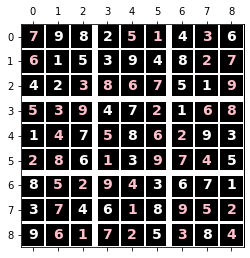

In [16]:
SolveSudokuFromCSV('sudoku_ex1.csv')

Filled 4 values
Generation #0: fitness = 30
min = 30, max = 47, mean = 39.91, std = 3.7177815965976264
### Total # of generations = 70, fitness = 0 ###


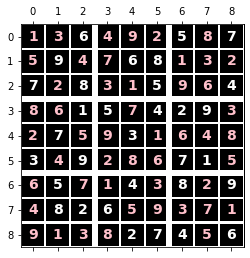

In [17]:
SolveSudokuFromCSV('sudoku_ex2.csv')

Filled 4 values
Generation #0: fitness = 31
min = 31, max = 51, mean = 41.51, std = 4.1388283366189516
Generation #100: fitness = 4
min = 4, max = 10, mean = 4.83, std = 1.5235156710713544
Generation #200: fitness = 4
min = 4, max = 8, mean = 4.72, std = 1.1838918869558992
Generation #300: fitness = 4
min = 4, max = 10, mean = 5.17, std = 1.625146147274146
Generation #400: fitness = 2
min = 2, max = 6, mean = 2.78, std = 1.3006152390311285
Generation #500: fitness = 2
min = 2, max = 10, mean = 3.06, std = 1.6602409463689298
### Total # of generations = 506, fitness = 0 ###


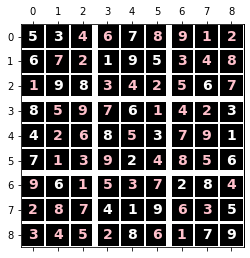

In [18]:
SolveSudokuFromCSV('sudoku_ex3.csv')

Filled 6 values
Generation #0: fitness = 17
min = 17, max = 35, mean = 24.99, std = 4.14848164995339
### Total # of generations = 23, fitness = 0 ###


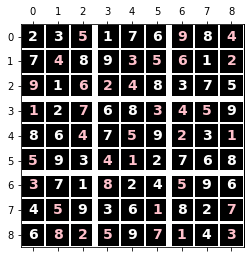

In [19]:
SolveSudokuFromCSV('sudoku_ex4.csv')

Filled 2 values
Generation #0: fitness = 34
min = 34, max = 56, mean = 44.64, std = 4.387527777689846
Generation #100: fitness = 6
min = 6, max = 13, mean = 7.57, std = 1.401820245252579
Generation #200: fitness = 4
min = 4, max = 12, mean = 5.61, std = 1.969238431475478
Generation #300: fitness = 4
min = 4, max = 12, mean = 5.38, std = 1.683923988783342
Generation #400: fitness = 3
min = 3, max = 10, mean = 4.97, std = 1.5585570249432645
Generation #500: fitness = 2
min = 2, max = 9, mean = 3.46, std = 1.7630655121123546
Generation #600: fitness = 2
min = 2, max = 10, mean = 3.11, std = 1.7994165721144173
Generation #700: fitness = 2
min = 2, max = 8, mean = 3.15, std = 1.6933694221876097
Generation #800: fitness = 2
min = 2, max = 9, mean = 3.33, std = 1.655626769534728
Generation #900: fitness = 2
min = 2, max = 10, mean = 3.04, std = 1.6728418933061184
Generation #1000: fitness = 2
min = 2, max = 10, mean = 3.11, std = 1.7372104075212078
Generation #1100: fitness = 2
min = 2, max =

Generation #8900: fitness = 2
min = 2, max = 16, mean = 7.12, std = 2.783091805887833
Generation #9000: fitness = 2
min = 2, max = 14, mean = 6.7, std = 2.5278449319529077
Generation #9100: fitness = 2
min = 2, max = 14, mean = 7.01, std = 2.439241685442424
Generation #9200: fitness = 2
min = 2, max = 14, mean = 7.41, std = 2.7896057069055478
Generation #9300: fitness = 2
min = 2, max = 16, mean = 7.33, std = 3.25593304599465
Generation #9400: fitness = 2
min = 2, max = 13, mean = 6.54, std = 2.732837353374694
-----Stale after 1500 generations, bumping Pm and reducing Pr-----
Pm = 0.75, Pr = 0.3985807500000001
Generation #9500: fitness = 2
min = 2, max = 14, mean = 7.2, std = 2.7820855486487113
Generation #9600: fitness = 2
min = 2, max = 19, mean = 8.54, std = 3.041118215393805
Generation #9700: fitness = 2
min = 2, max = 15, mean = 8.16, std = 2.827437001950707
Generation #9800: fitness = 2
min = 2, max = 16, mean = 7.52, std = 3.1542986542177642
Generation #9900: fitness = 2
min = 2

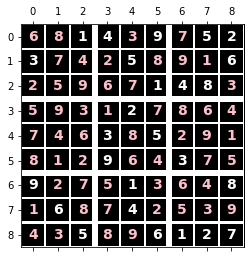

In [23]:
SolveSudokuFromCSV('sudoku_ex5.csv')

There is room for improvement. This algorithm was not able to solve a sudoku catalogued as "hard" (see below) in less than 100K generations, even with the stale improvement. We tried different crossover techniques and even a different genotype definition, but there wasn't a noticeable improvement. One option could be to come up with a better preprocessing technique to try to take some of the difficulty away from the genetic algorithm. Trying a different fitness function might also be worth the try.

In [ ]:
# Omitting output to keep the file size small
SolveSudokuFromCSV('sudoku_hard.csv')